### CSCN8020-25F-Sec1-Reinforcement Learning Programming
### Assignment one 
#### Name : Haysam Elamin
#### StID : 8953681

### Problem 1 – Pick-and-Place Robot (MDP Formulation)

We model the repetitive **pick-and-place task** of a robot arm as a **Markov Decision Process (MDP)**:

### 1. States (S)
We define simple, intuitive states that represent stages of the task:

- **Idle** – Robot is waiting at start position.  
- **Hold Object** – Robot has successfully gripped the object.  
- **Moving** – Robot is carrying the object toward the goal location.  
- **End Goal** – Robot has reached the target location with the object.  
- **Release** – Robot has placed the object at the goal (terminal state).  

Formally:  

$$
S = \{\text{Idle}, \text{HoldObject}, \text{Moving}, \text{EndGoal}, \text{Release}\}
$$

---

### 2. Actions (A)
The robot can perform high-level actions to transition between states:

- **Move Toward Object** – Navigate to the object’s location.  
- **Pickup** – Close the gripper to grasp the object.  
- **Move to Goal** – Carry the object toward the goal.  
- **Release** – Open the gripper to drop the object.  
- **Stop** – Terminate the task.  

Formally:  

$$
A = \{\text{MoveTowardObject}, \text{Pickup}, \text{MoveToGoal}, \text{Release}, \text{Stop}\}
$$

---

### 3. Transition Model (P)
Transitions are **stochastic**, representing uncertainty (slips, failures).  
Example probabilities:

- From **Idle**:  
  - MoveTowardObject → HoldObject (0.90), Idle (0.10)  
  - Pickup / MoveToGoal / Release → Idle (1.00)  
  - Stop → Release (1.00, terminal)

- From **HoldObject**:  
  - MoveToGoal → Moving (0.90), HoldObject (0.08), Idle (0.02)  
  - Release → Idle (0.98), HoldObject (0.02)  

- From **Moving**:  
  - MoveToGoal → Moving (0.90), HoldObject (0.05), Idle (0.05)  
  - Release → EndGoal (0.95), Moving (0.05)  

- From **EndGoal**:  
  - Release → Release (0.98, terminal), EndGoal (0.02)

---

### 4. Reward Function (R)
Rewards encourage **fast and smooth** completion:

- **+10** for successfully releasing the object at the goal.  
- **–1** penalty per step (to encourage speed).  
- **–5** penalty for invalid actions (e.g., trying to release with no object).  
- **0** otherwise.  

Formally:  

$$
R(s,a,s') =
\begin{cases}
+10, & \text{if task completed (Release at EndGoal)} \\
-5, & \text{if invalid action taken} \\
-1, & \text{each time step (delay penalty)} \\
0, & \text{otherwise}
\end{cases}
$$

---

### 5. Discount Factor (γ)
We choose:  

$$
\gamma = 0.95
$$

This ensures the agent values completing the task quickly rather than delaying.

---

### ✅ Summary
This MDP captures the essential logic of a pick-and-place robot:  
- States track the **progress stage** (Idle → Pick → Move → Goal → Release).  
- Actions represent **key operations** (Move, Pickup, Place).  
- The stochastic transition model reflects real-world uncertainty.  
- Rewards enforce the requirement for **fast and smooth movements**.


First Episode Trace (s, a, s', r):
(Idle      , MoveTowardObject) -> (HoldObject)   r = -1.0
(HoldObject, MoveToGoal      ) -> (Moving    )   r = -1.0
(Moving    , Release         ) -> (EndGoal   )   r = -1.0
(EndGoal   , Release         ) -> (Release   )   r = +10.0

First Episode: steps = 4, return = 7.0, success = True


,episode,steps,return,success
0,1,4,7.0,True
1,2,4,7.0,True
2,3,4,7.0,True
3,4,4,7.0,True
4,5,5,6.0,True
5,6,4,7.0,True
6,7,4,7.0,True
7,8,4,7.0,True
8,9,4,7.0,True
9,10,4,7.0,True



Summary:
          episode      steps     return success
count   30.000000  30.000000  30.000000      30
unique        NaN        NaN        NaN       1
top           NaN        NaN        NaN    True
freq          NaN        NaN        NaN      30
mean    15.500000   4.233333   6.766667     NaN
std      8.803408   0.568321   0.568321     NaN
min      1.000000   4.000000   5.000000     NaN
25%      8.250000   4.000000   7.000000     NaN
50%     15.500000   4.000000   7.000000     NaN
75%     22.750000   4.000000   7.000000     NaN
max     30.000000   6.000000   7.000000     NaN


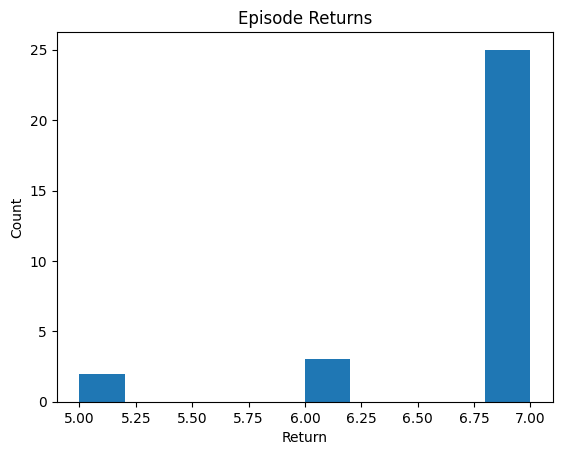

In [4]:
# ================================================================
# Problem 1 — Pick-and-Place Robot as an MDP (Option B: Stochastic)
# ---------------------------------------------------------------
# This cell implements a small simulator to generate episodes and returns for the simplified 5-state, 5-action MDP.
#
# Resul :
#   • Clear definitions of States, Actions, Transition Probabilities
#   • Reward function that encourages "fast and smooth" completion
#   • A simple hand-crafted policy
#   • Episode runner + batch evaluation + quick summaries
#
#  local values :
#   - the probabilities p_reach, p_nav, p_arrive, p_place
#   - the reward weights / logic in reward_fn
#   - the policy() function ( random or any other logic)
#
# Dependencies: only Python stdlib + pandas/numpy/matplotlib 
# ================================================================

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, Tuple, List
import random
from math import isclose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1) MDP Building Blocks
# -----------------------------

# Discrete state space 
STATES = ["Idle", "HoldObject", "Moving", "EndGoal", "Release"]   # "Release" is terminal

# Discrete action space (tasks)
ACTIONS = ["MoveTowardObject", "Pickup", "MoveToGoal", "Release", "Stop"]

# --- Transition probabilities (stochastic realism) ---
# Intuition:
#   p_reach : success reaching the object from "Idle" via MoveTowardObject
#   p_nav   : progress while moving toward the goal
#   p_arrive: being correctly aligned at the goal when releasing from "Moving"
#   p_place : successful place when at the goal and releasing
#
#  different amounts of noise/failure.
p_reach  = 0.90
p_nav    = 0.90
p_arrive = 0.95
p_place  = 0.98


# Transition kernel P(s'|s,a), represented as:
#   P[state][action] = list of (probability, next_state) pairs
# Each row must sum to 1.0.
P: Dict[str, Dict[str, List[Tuple[float, str]]]] = {
    "Idle": {
        "MoveTowardObject": [(p_reach, "HoldObject"), (1 - p_reach, "Idle")],
        # Invalid actions in this state lead to self-loop 
        "Pickup":           [(1.0, "Idle")],
        "MoveToGoal":       [(1.0, "Idle")],
        "Release":          [(1.0, "Idle")],
        # Stop ends the episode (transition to terminal)
        "Stop":             [(1.0, "Release")],
    },
    "HoldObject": {
        # Mostly progress to "Moving", with small chance of no progress or drop-back to Idle
        "MoveToGoal":       [(p_nav, "Moving"), (0.08, "HoldObject"), (0.02, "Idle")],
        # Already holding, "Pickup" has no effect (self-loop)
        "Pickup":           [(1.0, "HoldObject")],
        # Release here means we let go before moving—fall back to Idle most of the time
        "Release":          [(0.98, "Idle"), (0.02, "HoldObject")],
        # No reason to "MoveTowardObject" again (self-loop)
        "MoveTowardObject": [(1.0, "HoldObject")],
        "Stop":             [(1.0, "Release")],
    },
    "Moving": {
        # Keep moving with high probability; sometimes slip back
        "MoveToGoal":       [(p_nav, "Moving"), (0.05, "HoldObject"), (0.05, "Idle")],
        # Try to release: usually means we've aligned at goal; small chance we're not there yet
        "Release":          [(p_arrive, "EndGoal"), (1 - p_arrive, "Moving")],
        "Pickup":           [(1.0, "Moving")],          # no effect while moving
        "MoveTowardObject": [(1.0, "Moving")],          # no effect while moving
        "Stop":             [(1.0, "Release")],
    },
    "EndGoal": {
        # At the goal: releasing typically places successfully and ends the episode
        "Release":          [(p_place, "Release"), (1 - p_place, "EndGoal")],
        # Other actions are irrelevant here—self-loops
        "MoveToGoal":       [(1.0, "EndGoal")],
        "MoveTowardObject": [(1.0, "EndGoal")],
        "Pickup":           [(1.0, "EndGoal")],
        "Stop":             [(1.0, "Release")],
    },
    "Release": {
        # Terminal: no further transitions (episode ends)
        
    }
}

# Helper: a quick sanity check to ensure all rows sum to ~1.0
def _check_transition_sums(P: Dict[str, Dict[str, List[Tuple[float, str]]]]):
    for s, a_dict in P.items():
        for a, pairs in a_dict.items():
            total = sum(p for p, _ in pairs)
            if not isclose(total, 1.0, rel_tol=1e-9, abs_tol=1e-9):
                raise ValueError(f"Transition probs for ({s}, {a}) sum to {total:.6f}, not 1.0")
_check_transition_sums(P)


# -----------------------------
# 2) Validity + Rewards
# -----------------------------

def is_terminal(state: str) -> bool:
    """Terminal check: episode ends when we reach 'Release'."""
    return state == "Release"

def is_invalid_action(state: str, action: str) -> bool:
    """
    Define which actions are 'invalid' in each state (for reward penalties).
    We still allow the transition (often self-loop), but penalize the attempt.
    """
    if state == "Idle" and action in ("Pickup", "MoveToGoal", "Release"):
        return True
    if state == "HoldObject" and action in ("MoveTowardObject",):
        return True
    if state == "Moving" and action in ("MoveTowardObject", "Pickup"):
        return True
    if state == "EndGoal" and action in ("MoveToGoal", "MoveTowardObject", "Pickup"):
        return True
    if state == "Release":
        return True  # shouldn't act in terminal
    return False

def reward_fn(s: str, a: str, s_next: str) -> float:
    """
    Reward shaping aligned with 'fast and smooth' goals:
      +10 for successful place (EndGoal --Release--> Release)
      -5  for invalid actions (trying things that don't make sense in this state)
      -1  per time step otherwise (to encourage speed)
    """
    # Success bonus: placing at the goal ends the episode
    if s == "EndGoal" and a == "Release" and s_next == "Release":
        return 10.0
    # Penalize invalid attempts (keeps policy sensible)
    if is_invalid_action(s, a):
        return -5.0
    # Small per-step time penalty
    return -1.0


# -----------------------------
# 3) Policy + Dynamics Sampler
# -----------------------------

def policy(state: str, mode: str = "handcrafted") -> str:
    """
    Simple action selection.
      - "handcrafted": a sensible, greedy task policy
      - "random": sample any available action uniformly
    """
    if mode == "random":
        # Choose uniformly among all defined actions for this state
        return random.choice(list(P.get(state, {}).keys())) if state in P else "Stop"

    # Hand-crafted 'reasonable' mapping for this task:
    if state == "Idle":
        return "MoveTowardObject"
    if state == "HoldObject":
        return "MoveToGoal"
    if state == "Moving":
        return "Release"
    if state == "EndGoal":
        return "Release"
    # For terminal or unknowns
    return "Stop"

def sample_next_state(state: str, action: str) -> str:
    """
    Sample s' ~ P(s'|s,a) using the categorical distribution defined in P.
    If no transitions exist (e.g., terminal), we return the same state.
    """
    outcomes = P.get(state, {}).get(action, [])
    if not outcomes:
        return state  # No defined transition; stay put
    r = random.random()
    cum = 0.0
    for prob, ns in outcomes:
        cum += prob
        if r <= cum or isclose(cum, 1.0, rel_tol=1e-12, abs_tol=1e-12):
            return ns
    # Numerical fallback
    return outcomes[-1][1]


# -----------------------------
# 4) Episode + Batch Runners
# -----------------------------

@dataclass
class Step:
    s: str
    a: str
    s_next: str
    r: float

@dataclass
class EpisodeResult:
    trace: List[Step]
    total_return: float
    steps: int
    success: bool  # True iff we placed successfully (EndGoal --Release--> Release)

def run_episode(max_steps: int = 100, policy_mode: str = "handcrafted", seed: int | None = None) -> EpisodeResult:
    if seed is not None:
        random.seed(seed)

    s = "Idle"
    total = 0.0
    trace: List[Step] = []

    for t in range(max_steps):
        if is_terminal(s):
            break

        a = policy(s, mode=policy_mode)
        s_next = sample_next_state(s, a)
        r = reward_fn(s, a, s_next)

        total += r
        trace.append(Step(s=s, a=a, s_next=s_next, r=r))
        s = s_next

        if is_terminal(s):
            break

    # Success criterion: at some step we performed EndGoal --Release--> Release
    success = any(step.s == "EndGoal" and step.a == "Release" and step.s_next == "Release" for step in trace)
    return EpisodeResult(trace=trace, total_return=total, steps=len(trace), success=success)

def run_n_episodes(n: int = 30, max_steps: int = 100, policy_mode: str = "handcrafted", seed: int = 123):
    random.seed(seed)
    results = [run_episode(max_steps=max_steps, policy_mode=policy_mode) for _ in range(n)]

    # Build a small summary table 
    df = pd.DataFrame({
        "episode": np.arange(1, n + 1),
        "steps":   [r.steps for r in results],
        "return":  [r.total_return for r in results],
        "success": [r.success for r in results],
    })
    return results, df


# -----------------------------
# 5) Demo / Reporting
# -----------------------------
if __name__ == "__main__":
    # Try one episode and print its step-by-step trace
    ep = run_episode(max_steps=50, policy_mode="handcrafted", seed=7)
    print("First Episode Trace (s, a, s', r):")
    for step in ep.trace:
        print(f"({step.s:10s}, {step.a:16s}) -> ({step.s_next:10s})   r = {step.r:+.1f}")
    print(f"\nFirst Episode: steps = {ep.steps}, return = {ep.total_return:.1f}, success = {ep.success}")

    # Run a small batch of episodes and summarize
    results, df = run_n_episodes(n=30, max_steps=50, policy_mode="handcrafted", seed=7)
    display(df.head(10))  
    print("\nSummary:")
    print(df.describe(include='all'))

    # Quick histogram of returns 
    plt.figure()
    plt.hist(df["return"], bins=10)
    plt.title("Episode Returns")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.show()


### Problem 2 — 2×2 Gridworld (Value Iteration) — Cell 1/2
####  Iteration 1**

### Problem Setup
- **States:**  
  $$
  S = \{s_1, s_2, s_3, s_4\}
  $$



- **Actions:**  
  $$
  A = \{\text{up}, \text{down}, \text{left}, \text{right}\}
  $$

- **Transitions:** Deterministic. If an action would leave the grid → the agent **stays** in the same state.  

- **Rewards (state-based):**  
  $$
  R(s_1)=5, \quad R(s_2)=10, \quad R(s_3)=1, \quad R(s_4)=2
  $$

- **Discount factor:**  
  $$
  \gamma = 1
  $$

- **Initial values (convention):**  
  $$
  V^{(0)}(s)=0 \quad \forall s \in S
  $$

---

### Bellman Optimality Update
For deterministic transitions, state-based rewards, and \(\gamma=1\):

$$
V^{(k+1)}(s) = \max_{a \in A} \Big[ R(s) + V^{(k)}(s'(s,a)) \Big]
$$

> *In words:* “The new value of a state equals the reward of that state plus the **largest old value** among the states you can reach.”

---

### Iteration 1
Since \(V^{(0)}(s)=0\) for all states:

$$
V^{(1)}(s) = R(s)
$$

So:

$$
V^{(1)}(s_1)=5, \quad V^{(1)}(s_2)=10, \quad V^{(1)}(s_3)=1, \quad V^{(1)}(s_4)=2
$$

**Grid after Iteration 1**
| s1 = 5 | s2 = 10 |
|---------|---------|
| s3 = 1  | s4 = 2 |

## Problem 2 — 2×2 Gridworld (Value Iteration) — Cell 2/2
### **Iteration 2**

We now compute:

$$
V^{(2)} \;\; \text{using} \;\; V^{(1)}.
$$

Neighborhoods:  
- \(s_1\): Right → \(s_2\), Down → \(s_3\), Up/Left → stay in \(s_1\)  
- \(s_2\): Left → \(s_1\), Down → \(s_4\), Up/Right → stay in \(s_2\)  
- \(s_3\): Up → \(s_1\), Right → \(s_4\), Left/Down → stay in \(s_3\)  
- \(s_4\): Up → \(s_2\), Left → \(s_3\), Right/Down → stay in \(s_4\)  

Recall values from Iteration 1:

$$
V^{(1)}(s_1)=5, \quad V^{(1)}(s_2)=10, \quad V^{(1)}(s_3)=1, \quad V^{(1)}(s_4)=2
$$

---

### Detailed Updates

**1) State \(s_1\), reward = 5**

$$
\begin{aligned}
\text{Right: } & 5 + V^{(1)}(s_2) = 5 + 10 = 15 \\
\text{Down: }  & 5 + V^{(1)}(s_3) = 5 + 1  = 6 \\
\text{Up/Left: } & 5 + V^{(1)}(s_1) = 5 + 5  = 10 \\
\end{aligned}
$$  

$$
V^{(2)}(s_1) = 15
$$

---

**2) State \(s_2\), reward = 10**

$$
\begin{aligned}
\text{Left: } & 10 + V^{(1)}(s_1) = 10 + 5 = 15 \\
\text{Down: } & 10 + V^{(1)}(s_4) = 10 + 2 = 12 \\
\text{Up/Right: } & 10 + V^{(1)}(s_2) = 10 + 10 = 20 \\
\end{aligned}
$$  

$$
V^{(2)}(s_2) = 20
$$

---

**3) State \(s_3\), reward = 1**

$$
\begin{aligned}
\text{Up: } & 1 + V^{(1)}(s_1) = 1 + 5 = 6 \\
\text{Right: } & 1 + V^{(1)}(s_4) = 1 + 2 = 3 \\
\text{Left/Down: } & 1 + V^{(1)}(s_3) = 1 + 1 = 2 \\
\end{aligned}
$$  

$$
V^{(2)}(s_3) = 6
$$

---

**4) State \(s_4\), reward = 2**

$$
\begin{aligned}
\text{Up: } & 2 + V^{(1)}(s_2) = 2 + 10 = 12 \\
\text{Left: } & 2 + V^{(1)}(s_3) = 2 + 1  = 3 \\
\text{Right/Down: } & 2 + V^{(1)}(s_4) = 2 + 2 = 4 \\
\end{aligned}
$$  

$$
V^{(2)}(s_4) = 12
$$

---

### Grid after Iteration 2
| s1 = 15 | s2 = 20 |
|---------|---------|
| s3 = 6  | s4 = 12 |